# Parameter optimization of PID control based on Twiddle and Bayesian Optimization

In [1]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# You don't have to use the exact values as shown in the video
# play around with different values! This quiz isn't graded just see
# how low of an error you can get.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
#
# No cheating!
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)



Final twiddle error = 6.486248420974659e-16
optimal parameters:  [2.9331227688652457, 10.326589894591526, 0.49316041639454505]


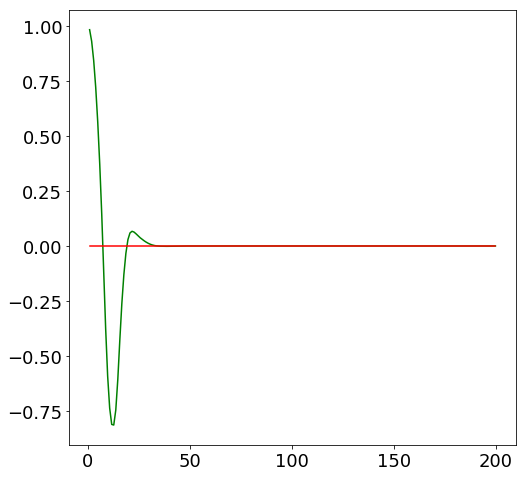

In [102]:
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # Don't forget to call `make_robot` before every call of `run`!
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)
    # TODO: twiddle loop here

    while sum(dp) > tol:
        
        for i in range(len(p)):
            
            p[i] += dp[i]
            
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)
            
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2*dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot,p)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        
    
    return p, best_err


params, err = twiddle()
print("Final twiddle error = {}".format(err))

print("optimal parameters: ", params)
robot = make_robot()
x_trajectory_twiddle, y_trajectory_twiddle, err = run(robot, params)
n = len(x_trajectory_twiddle)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(x_trajectory_twiddle, y_trajectory_twiddle, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory_twiddle, np.zeros(n), 'r', label='reference')


## Bayesian optimization based on Hyperopt

In [79]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import seaborn as sns
import numpy as np
from hyperopt import STATUS_OK

In [80]:
def objective(params):
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    x_trajectory = []
    y_trajectory = []
    
#     robot = params['robot']
    robot = make_robot()
#     n = params['n']
    n = 100
    speed = 1.0
#     speed = params['speed']
    
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params['p1'] * cte - params['p2'] * diff_cte - params['p3'] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return {'loss': err / n, 'params': params, 'status': STATUS_OK, 'x_trajectory':x_trajectory, 'y_trajectory':y_trajectory, 'iteration': ITERATION}     

In [81]:
par = {'robot': make_robot(), 'n':100, 'speed':1.0, 'p1':2.9331227688652457, 'p2':10.326589894591526, 'p3':0.49316041639454505}

data = objective(par)

data['loss']

6.486248419977637e-16

In [82]:
# create all the samples for the parameters

p1 = {'p1': hp.uniform('p1', 0, 5)}
p2 = {'p2': hp.uniform('p2', 0, 15)}
p3 = {'p3': hp.uniform('p3', 0, 5)}

Text(0, 0.5, 'Density')

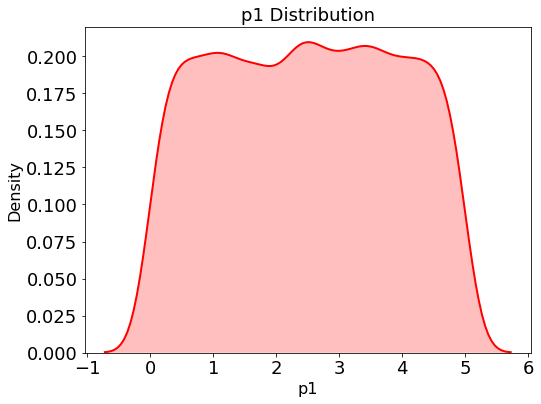

In [83]:
p1_list = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    p1_list.append(sample(p1)['p1'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(p1_list, color = 'red', linewidth = 2, shade = True);
plt.title('p1 Distribution', size = 18); 
plt.xlabel('p1', size = 16); plt.ylabel('Density', size = 16)

Text(0, 0.5, 'Density')

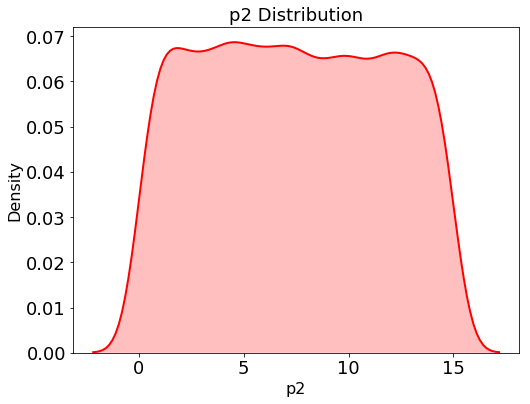

In [84]:
p2_list = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    p2_list.append(sample(p2)['p2'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(p2_list, color = 'red', linewidth = 2, shade = True);
plt.title('p2 Distribution', size = 18); 
plt.xlabel('p2', size = 16); plt.ylabel('Density', size = 16)

Text(0, 0.5, 'Density')

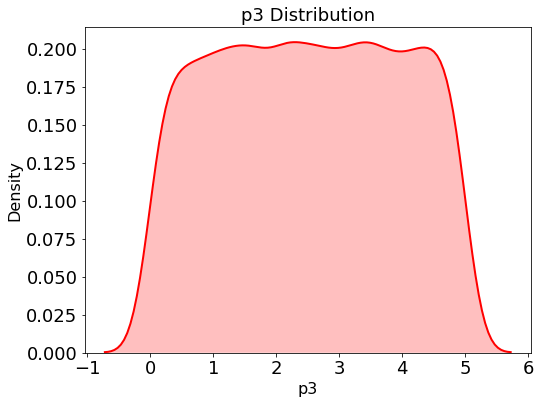

In [85]:
p3_list = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    p3_list.append(sample(p3)['p3'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(p3_list, color = 'red', linewidth = 2, shade = True);
plt.title('p3 Distribution', size = 18); 
plt.xlabel('p3', size = 16); plt.ylabel('Density', size = 16)

In [86]:
# Define the search space
space = {
    'p1': hp.uniform('p1', 0, 5),
    'p2': hp.uniform('p2', 0, 15),
    'p3': hp.uniform('p3', 0, 5)
}

In [87]:

# Sample from the full space
x = sample(space)

x

{'p1': 4.249764431581701, 'p2': 9.632601789916242, 'p3': 3.2904154598003315}

In [88]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [89]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [90]:
from hyperopt import fmin

In [91]:
# Global variable
global  ITERATION

ITERATION = 0
MAX_EVALS = 2000

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

min loss is  4.095239179129828e-20


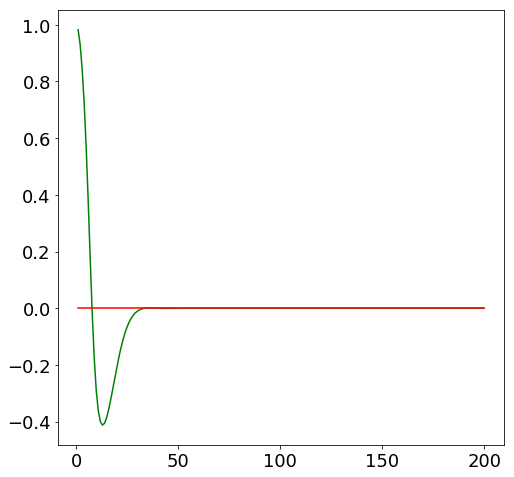

In [92]:
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])

print("min loss is ", bayes_trials_results[0]['loss'])

x_trajectory = bayes_trials_results[0]['x_trajectory']
y_trajectory = bayes_trials_results[0]['y_trajectory']

n = len(x_trajectory)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

In [93]:
import pandas as pd

results = pd.DataFrame.from_dict(bayes_trials_results)

results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,iteration,loss,params,status,x_trajectory,y_trajectory
0,1130,4.095239e-20,"{'p1': 1.7958960790149707, 'p2': 7.89255891058...",ok,"[0.9997957247711238, 1.9983660986061489, 2.994...","[0.9824965995194717, 0.9300078502682041, 0.842..."
1,802,4.807750e-20,"{'p1': 2.0538511840913274, 'p2': 8.19197423682...",ok,"[0.9997957247711238, 1.9983660986061489, 2.994...","[0.9824965995194717, 0.9300078502682041, 0.842..."
2,184,7.467236e-20,"{'p1': 2.2163169512659664, 'p2': 8.71336756629...",ok,"[0.9997957247711238, 1.9983660986061489, 2.994...","[0.9824965995194717, 0.9300078502682041, 0.842..."
3,1396,8.029450e-20,"{'p1': 1.5472027326436473, 'p2': 7.12586854614...",ok,"[0.9997957247711238, 1.9983660986061489, 2.994...","[0.9824965995194717, 0.9300078502682041, 0.842..."
4,612,1.098920e-19,"{'p1': 2.088834683478298, 'p2': 8.532098602346...",ok,"[0.9997957247711238, 1.9983660986061489, 2.994...","[0.9824965995194717, 0.9300078502682041, 0.842..."


In [95]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(results.loc[0, 'params'].keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(params.values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']


bayes_params.head()

,p1,p2,p3,loss,iteration
0,1.7959,7.89256,0.182766,4.095239e-20,1130
1,2.05385,8.19197,0.263379,4.807750e-20,802
2,2.21632,8.71337,0.249254,7.467236e-20,184
3,1.5472,7.12587,0.158038,8.029450e-20,1396
4,2.08883,8.5321,0.24527,1.098920e-19,612


Text(0.5, 1.0, 'p1 Distribution')

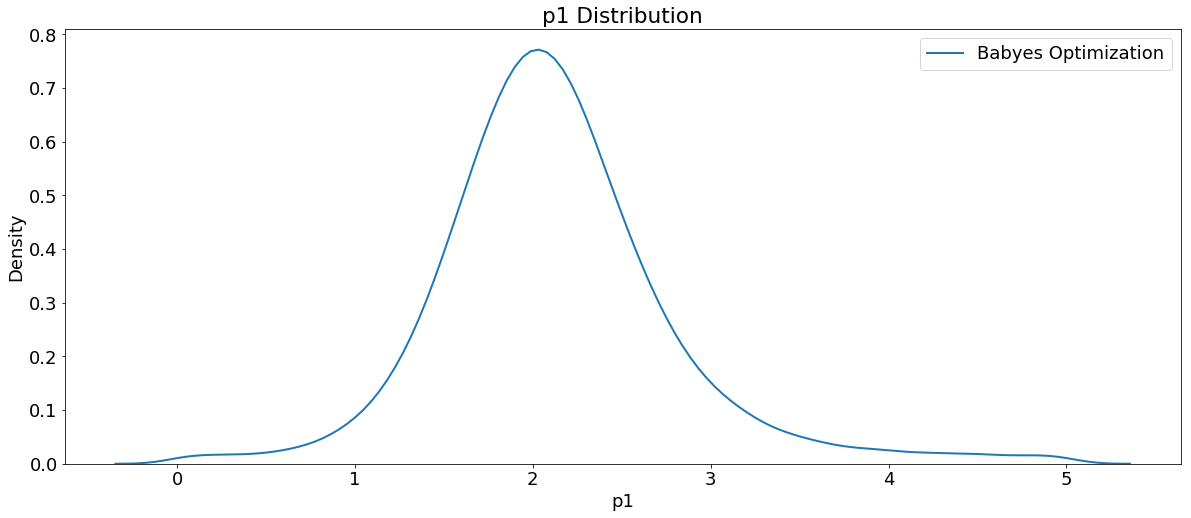

In [96]:

plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['p1'], label = 'Babyes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('p1')
plt.ylabel('Density')
plt.title('p1 Distribution')

Text(0.5, 1.0, 'p2 Distribution')

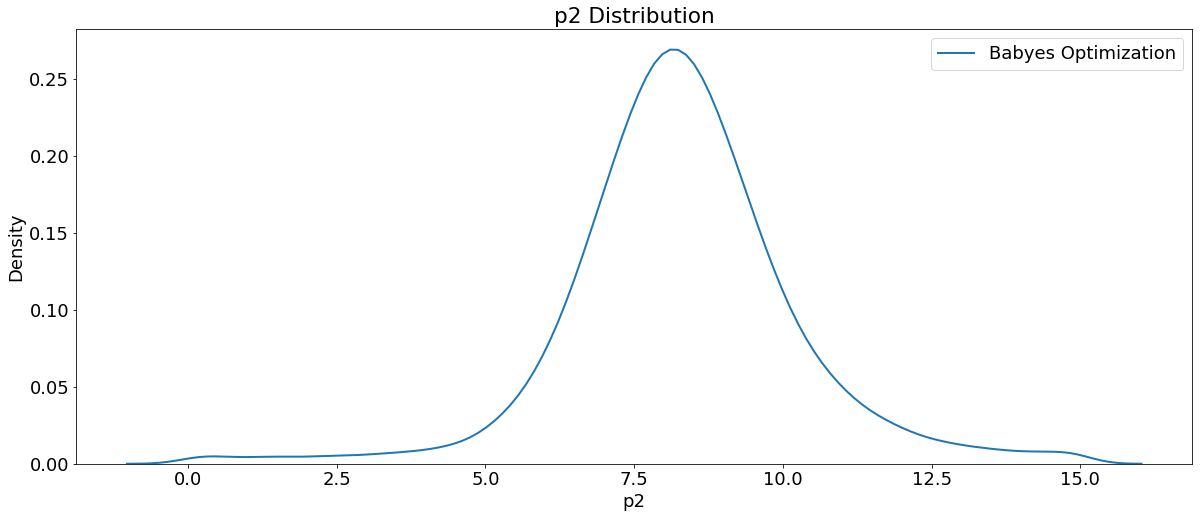

In [97]:

plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['p2'], label = 'Babyes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('p2')
plt.ylabel('Density')
plt.title('p2 Distribution')

Text(0.5, 1.0, 'p3 Distribution')

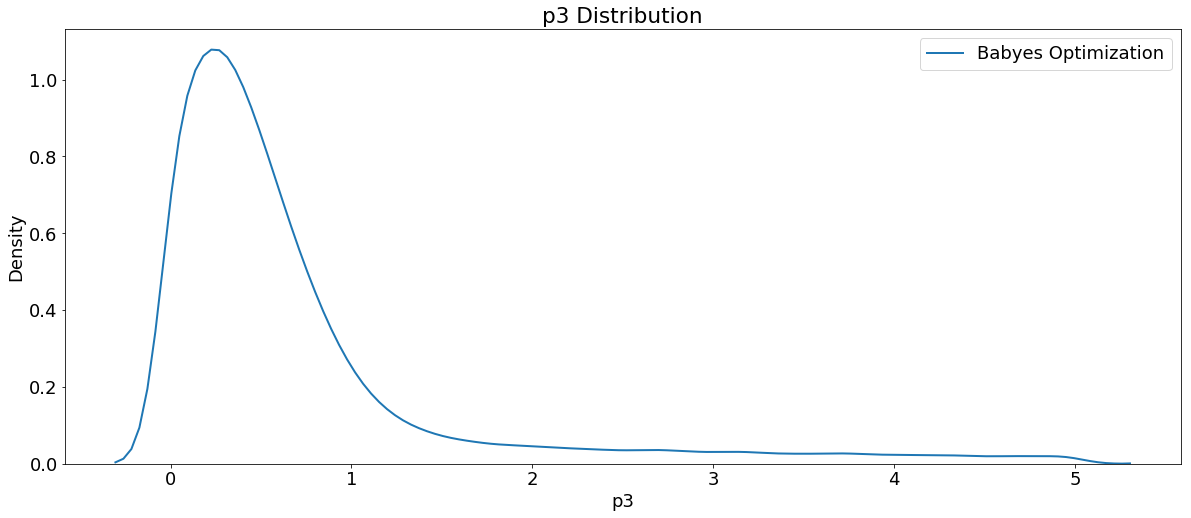

In [98]:

plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['p3'], label = 'Babyes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('p3')
plt.ylabel('Density')
plt.title('p3 Distribution')

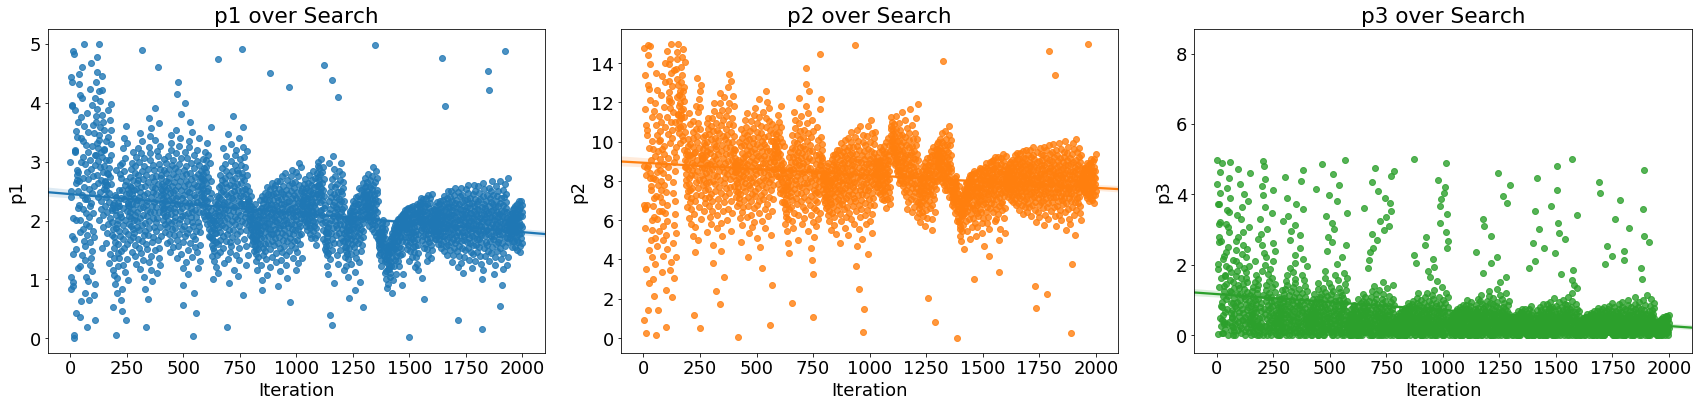

In [100]:

fig, axs = plt.subplots(1, 3, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['p1', 'p2', 'p3']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

make comparison with twiddle result

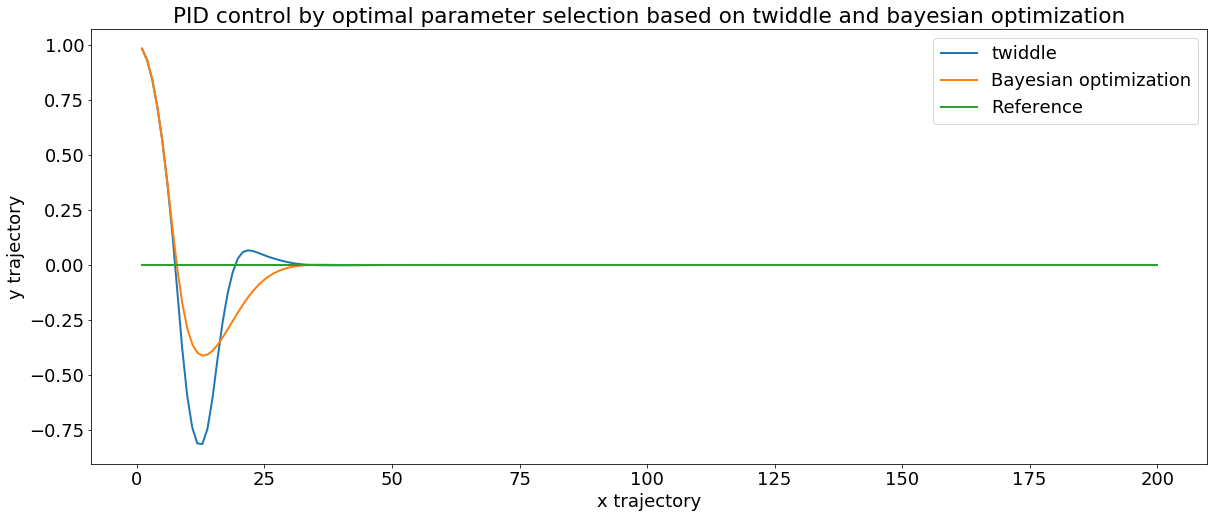

In [105]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
plt.plot(x_trajectory_twiddle, y_trajectory_twiddle, label = 'twiddle', linewidth = 2)
plt.plot(x_trajectory, y_trajectory, label = 'Bayesian optimization', linewidth = 2)
plt.plot(x_trajectory, np.zeros(n), label = 'Reference', linewidth = 2)

plt.legend()
plt.xlabel('x trajectory')
plt.ylabel('y trajectory')
plt.title('PID control by optimal parameter selection based on twiddle and bayesian optimization')

plt.savefig('./pid_control_opt_para_select')